In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from itertools import product
import hexMinisom
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colormaps
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.feature as cf
import pickle
import itertools
import igraph as ig
import colorsys
import random
import datetime as dt

In [2]:
def save_som(som, fileName):
    with open(fileName, 'wb') as outfile:
        pickle.dump(som, outfile)

def load_som(fileName):
    with open(fileName, 'rb') as infile:
        som = pickle.load(infile)
    return som

def generate_distinct_colors(n):
    colors = []
    # Generate `n` distinct colors in the HSV color space
    for i in range(n):
        # Generate a unique hue for each color, evenly spaced between 0 and 1
        hue = i / n
        # Use full saturation and value to get vibrant colors
        saturation = 1.0
        value = 1.0
        
        # Convert HSV to RGB (the result is a tuple of RGB values in [0, 1])
        rgb = colorsys.hsv_to_rgb(hue, saturation, value)
        
        # Convert RGB to a format that ranges from 0 to 255 and create a hex string
        rgb = [int(x * 255) for x in rgb]
        hex_color = f"#{rgb[0]:02x}{rgb[1]:02x}{rgb[2]:02x}"
        colors.append(hex_color)

    random.shuffle(colors)
    return colors

# Get the counts of each WR_label for each node in SOM
def get_WR_counts(l, return_percents=False, indices=None):

    # Take only the data from days with the given indices in indices
    if indices is None:
        labels, counts = np.unique([WR_labels[i] for i in l], return_counts=True)
    else:
        labels, counts = np.unique([WR_labels[i] for i in l if i in indices], return_counts=True)

    # If the node has no days of a given regime add the regime to the labels and 0 as its count
    if len(labels) != len(WR_labels_dict.keys()):
        missing_values = np.setdiff1d(list(WR_labels_dict.keys()), labels)
        labels = WR_labels_dict.keys()

        for v in missing_values:
           counts = np.insert(counts, v, 0)

    # Calculate the percents
    if return_percents:
        counts = 100 * counts / sum(counts)
    regime_counts = dict(zip(labels, counts))
    return regime_counts

def hex_heatmap(som, data, cmap='Blues', title='', cbLabel=''):
    # set up the figure
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    cmap = mpl.colormaps[cmap]
    
    # get data from the som
    weights = som.get_weights()
    xx, yy = som.get_euclidean_coordinates()
    
    maxCount = max(v for v in data.values())
    minCount = min(v for v in data.values())
    
    # loops through the neurons
    for i in range(weights.shape[0]):
        for j in range(weights.shape[1]):
            # Only use non-masked nodes
            if som._mask[i, j] == 0:
                # If theres no data still plot the hexagon
                if (i, j) not in data:
                    data[(i,j)] = 0
                    
                # determine the hexagon position and color
                wy = yy[(j, i)] * np.sqrt(3) / 2
                colorWeight = data[(i, j)]/maxCount
                
                # Create hexagon and add it to axis
                hex = patches.RegularPolygon((xx[(j, i)], wy), numVertices=6, radius=.85 / np.sqrt(3), 
                                        facecolor=cmap(colorWeight), edgecolor='grey')
                ax.add_patch(hex)
                
                # determine the color the text should be based on color of node
                if colorWeight >= .75:
                    textColor = 'white'
                else:
                    textColor = 'black'
                
                # add text to hexagon for its frequency
                plt.text(
                    xx[(j, i)], wy - .07, f'{data[(i, j)]}', 
                    {'horizontalalignment': 'center', 'color': textColor, 'fontsize': 17}
                )
            
    # align figure to show all hexagons
    plt.xlim(-1, weights.shape[0] - .5)
    plt.ylim(-1, (weights.shape[1] - .5) * np.sqrt(3) / 2)
    
    # remove the axis labels and lines
    ax.axis('off')
    
    # Create the color bar
    norm = mpl.colors.Normalize(vmin=minCount, vmax=maxCount)
    cb = fig.colorbar(mpl.cm.ScalarMappable(
        norm=norm, cmap=cmap), ax=ax, location='bottom', anchor=(.56, 2.3), shrink=.65, extend='both'
                     )
    cb.set_label(cbLabel, fontsize=17)
    cb.ax.tick_params(labelsize=17)
    
    # Title the plot
    plt.title(title, fontsize=17, y=.95, x=.515)
    return fig

def hex_frequency_plot(som, winmap=None, cmap='Blues', title='', cbLabel=''):
    if winmap == None:
        winmap = som.win_map(dataarray)
    data = {k: len(v) for k, v in winmap.items()}
    fig = hex_heatmap(som, data, 'Blues', title, cbLabel)
    return fig

def hex_plot(som, projection=None):
    """
    Create a matplot lib figure with an axis for each 
    neuron already positioned into the hexagonal shape
    """
    # Extract the needed data from the som
    n = som._num
    xy = (2 * n) - 1
    mask = som._mask
    node_indices_xy = np.ma.where(mask == False)
    node_indices = list(zip(node_indices_xy[0], node_indices_xy[1]))

    # create figure
    totRows = xy * 3
    totCols = xy * 2
    fig = plt.figure(figsize=[totRows, totCols])
    axs = {}
    
    for x, y in list(product(range(xy), range(xy))):

        # make a subplot for the nodes not masked
        if (y, x) in node_indices: # for showing in the proper orientation x and y must be switched
            
            # odd rows will be offset to keep the hexagonal shape
            if y % 2 == 0:
                curRow = x * 3
            else:
                curRow = (x * 3) + 1
                
            curCol = (totCols - 2) - (y * 2)

            ax = plt.subplot2grid(
                (totCols, totRows), (curCol, curRow), rowspan=2, colspan=2, projection=projection
            )
            ax.set_title(node_nums[(y, x)])
            
            if projection is not None:
                ax.set_extent([-180, -30, 20, 80], crs=projection)
            axs[(y, x)] = ax
    return fig, axs

def find_longest_consecutive_index(arr):
    if not arr.size:
        return -1  # Handle empty array

    max_len = 0
    start_index = -1
    current_len = 1
    current_start = 0

    for i in range(1, len(arr)):
        if arr[i] == arr[i - 1]:
            current_len += 1
        else:
            if current_len > max_len:
                max_len = current_len
                start_index = current_start
            current_len = 1
            current_start = i

    # Check if the last sequence is the longest
    if current_len > max_len:
        start_index = current_start
    return start_index

In [3]:
dataset = xr.open_dataarray('/glade/work/molina/DATA/Z500Anoms_ERA5.nc')

latSlice = slice(20, 80) #20N, 80N
lonSlice = slice(180, 330) #180W, 30W
dataarray = dataset.sel(lat=latSlice, lon=lonSlice)
dataarray = dataarray.stack(latlon=['lat', 'lon']).values

# Seasonal breakdown of the data
DJF = dataset.time.dt.month.isin([12, 1, 2])
DJF_idxs = np.array(DJF).nonzero()[0]
MAM = dataset.time.dt.month.isin([3, 4, 5])
MAM_idxs = np.array(MAM).nonzero()[0]
JJA = dataset.time.dt.month.isin([6, 7, 8])
JJA_idxs = np.array(JJA).nonzero()[0]
SON = dataset.time.dt.month.isin([9, 10, 11])
SON_idxs = np.array(SON).nonzero()[0]

print(dataarray.shape)

(30660, 9211)


In [4]:
som = load_som('SOM40.p')

n = som._num
xy = hexMinisom.xy_using_n(n)

mask = som._mask
node_indices_xy = np.ma.where(mask == False)
node_indices = list(zip(node_indices_xy[0], node_indices_xy[1]))
all_nodes = product(range(xy), range(xy))

inputLength = dataarray.shape[1]

winmap = som.win_map(dataarray, return_indices=True)

# Seasonal breakdown for winmap
DJF_winmap = {}
MAM_winmap = {}
JJA_winmap = {}
SON_winmap = {}

# Loop through each node
for k, v in winmap.items():
    
    # Keep only the days that are in the given season
    DJF_winmap[k] = [i for i in v if i in DJF_idxs]
    MAM_winmap[k] = [i for i in v if i in MAM_idxs]
    JJA_winmap[k] = [i for i in v if i in JJA_idxs]
    SON_winmap[k] = [i for i in v if i in SON_idxs]

w = som._weights
minimum_weight = -np.max(np.abs(w))
maximum_weight = np.max(np.abs(w))

# Calculate the node number for each coordinate
node_nums = {}
n = 1
for i in range(mask.shape[0])[::-1]:
    for j in range(mask.shape[1]):
        # only use non masked nodes
        if som._mask[i, j] == 0:
            node_nums[(i, j)] = n
            n += 1

color_list = generate_distinct_colors(len(node_indices))

In [5]:
print(som._sigma_decay_function)
print(som._learning_rate_decay_function)
print(som._learning_rate)
print(som.neighborhood)
print(som._activation_distance)

<bound method MiniSom._asymptotic_decay of <hexMinisom.MiniSom object at 0x14e29ac6f620>>
<bound method MiniSom._asymptotic_decay of <hexMinisom.MiniSom object at 0x14e29ac6f620>>
0.001
<bound method MiniSom._gaussian of <hexMinisom.MiniSom object at 0x14e29ac6f620>>
<bound method MiniSom._euclidean_distance of <hexMinisom.MiniSom object at 0x14e29ac6f620>>


In [6]:
# Import the regime labels
WR_labels_df = pd.read_csv('df_labels_nocorrfilt_ERA5.csv')
WR_labels_df.rename(columns={'Unnamed: 0': 'date'}, inplace=True)
WR_labels_df['date'] = pd.to_datetime(WR_labels_df['date'], format='%Y-%m-%d')
WR_labels_dict = {
    0: 'Polar High', 
    1: 'Pacific Trough', 
    2: 'Pacific Ridge', 
    3: 'Alaskan Ridge', 
    4: 'Atlantic Ridge', 
    5: 'No WR'
}
WR_labels = np.array(WR_labels_df['WR'])

WRs_by_node = {k: get_WR_counts(v) for k, v in winmap.items()}
WRs_percents = {k: get_WR_counts(v, return_percents=True) for k, v in winmap.items()}

print(WR_labels_df)

# Calculate the 90th percentile of the distances and only keep data less than that
percentile90 = np.percentile(WR_labels_df['distances'], 90)
lt90 = (np.array(WR_labels_df['distances']) < percentile90).nonzero()[0]
WRs_lt90 = {k: get_WR_counts(v, True, lt90) for k, v in winmap.items()}

# Calculate the variances of the distances for each WR
WR_indices = {i: (WR_labels == i).nonzero()[0] for i in np.unique(WR_labels)}
for WR, idxs in WR_indices.items():
    variance = np.var(WR_labels_df['distances'].iloc[idxs])
    
# Get the WR counts for each specific season
WRs_DJF = {k: get_WR_counts(v, True, DJF_idxs) for k, v in winmap.items()}
WRs_MAM = {k: get_WR_counts(v, True, MAM_idxs) for k, v in winmap.items()}
WRs_JJA = {k: get_WR_counts(v, True, JJA_idxs) for k, v in winmap.items()}
WRs_SON = {k: get_WR_counts(v, True, SON_idxs) for k, v in winmap.items()}

            date  WR  distances      corr
0     1940-01-01   0   2.463938  0.518457
1     1940-01-02   0   2.662645  0.565398
2     1940-01-03   0   2.916932  0.552532
3     1940-01-04   0   3.122750  0.495652
4     1940-01-05   0   3.302769  0.394692
...          ...  ..        ...       ...
30655 2023-12-27   1   2.823370  0.857459
30656 2023-12-28   1   2.687266  0.837698
30657 2023-12-29   1   2.394127  0.781903
30658 2023-12-30   1   2.253624  0.655454
30659 2023-12-31   0   2.468174  0.359541

[30660 rows x 4 columns]


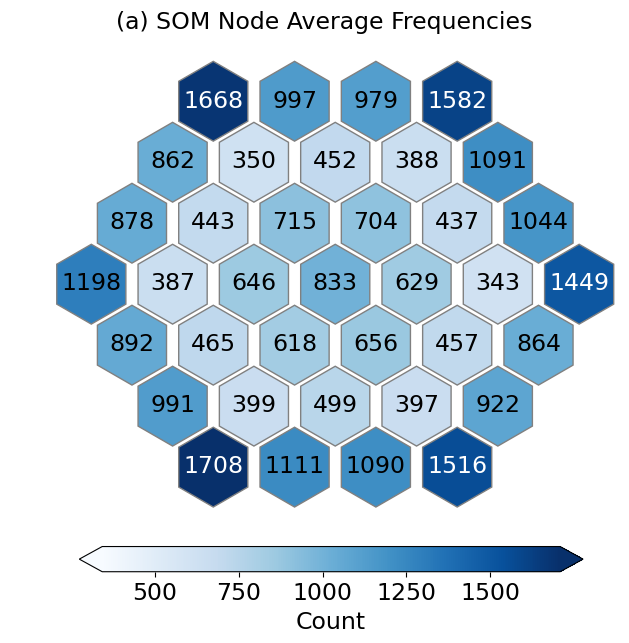

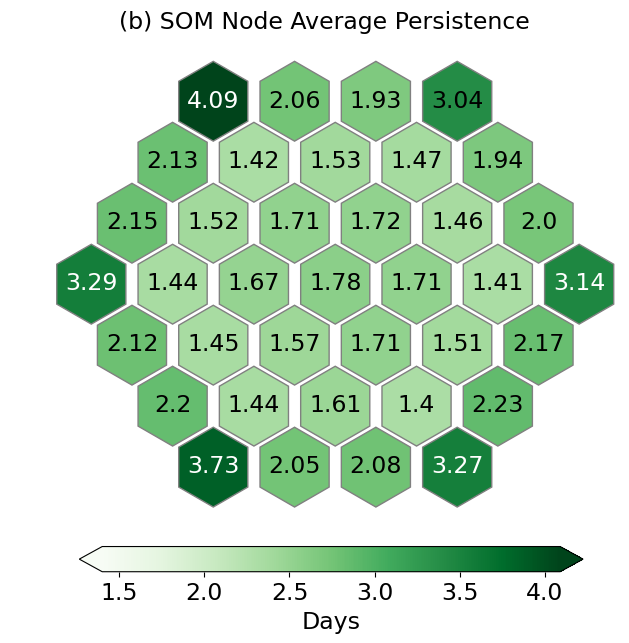

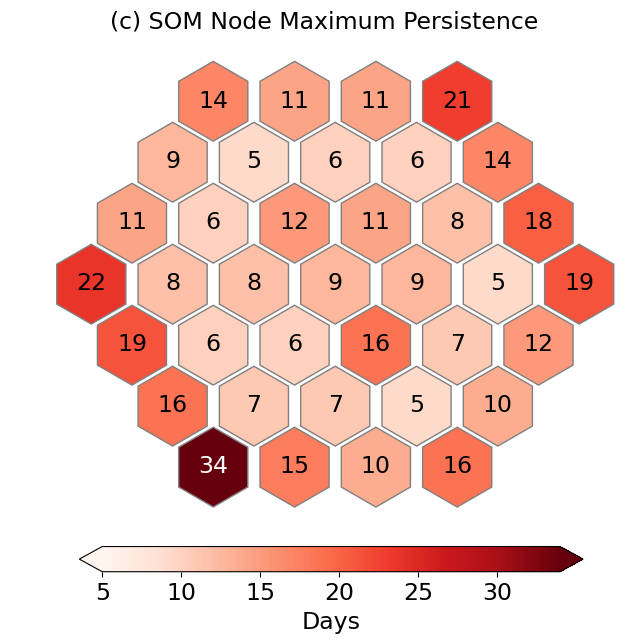

In [7]:
# Determine how consistant each weather regime is
regimePersistences = {}

for neuron in winmap:
    idxs = np.array(winmap[neuron])
    
    persistencesList = []
    diffs = np.diff(idxs)
    groups = np.split(diffs, np.where(diffs != 1)[0]+1)
    persistencesList = [len(l) for l in groups]
    persistencesList[-1] += 1
    numDays, count = np.unique(persistencesList, return_counts=True)
    #count = count / sum(count)
    
    regimePersistences[neuron] = (numDays, count)

# Caluculate the average persistence for each node
averagePersistences = {k: round(sum(v[0] * v[1]) / sum(v[1]), 2) for k, v in regimePersistences.items()}
maxPersistences = {k: max(v[0]) for k, v in regimePersistences.items()}

# Frequency plot
p = hex_frequency_plot(som, winmap, 'Blues', '(a) SOM Node Average Frequencies', 'Count')
p.savefig('SOM_frequencies.pdf', transparent=True, bbox_inches='tight')

# Persistences
fig = hex_heatmap(som, averagePersistences, 'Greens', '(b) SOM Node Average Persistence', 'Days')
fig.savefig('SOM_persistences.pdf', transparent=True, bbox_inches='tight')

# Max persistence
fig = hex_heatmap(som, maxPersistences, 'Reds', '(c) SOM Node Maximum Persistence', 'Days')
plt.savefig('SOM_max_persistences.pdf', transparent=True, bbox_inches='tight')

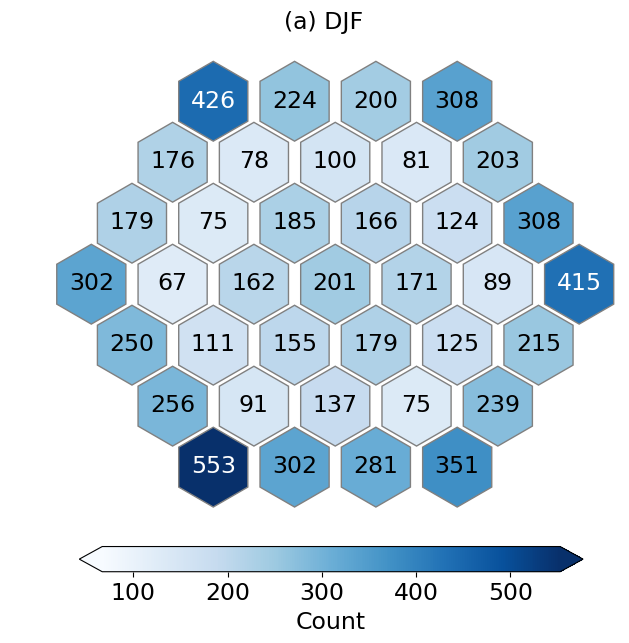

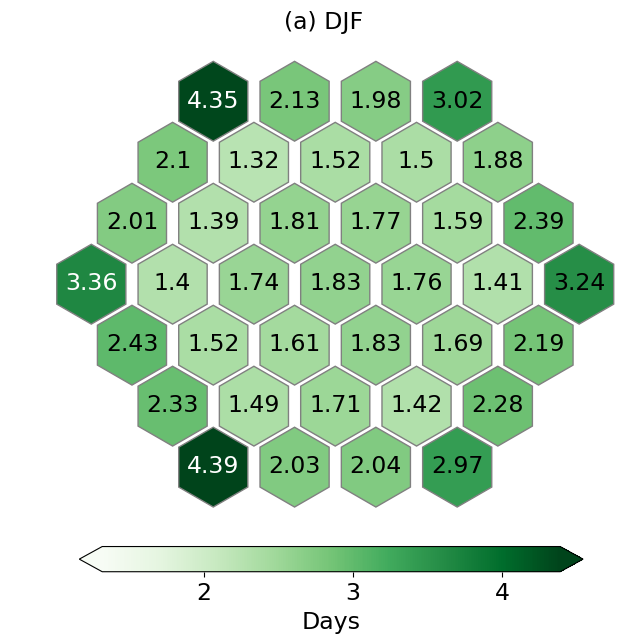

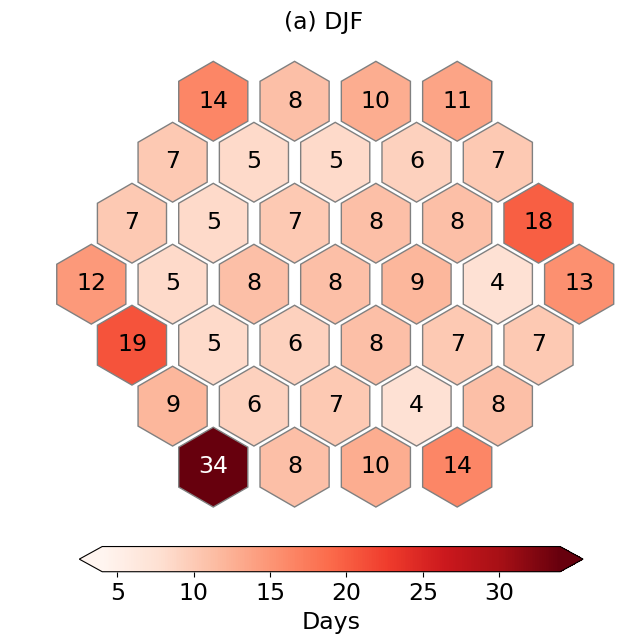

In [8]:
# Determine how consistant each weather regime is
regimePersistences = {}

for neuron in DJF_winmap:
    idxs = np.array(DJF_winmap[neuron])
    
    persistencesList = []
    diffs = np.diff(idxs)
    groups = np.split(diffs, np.where(diffs != 1)[0]+1)
    persistencesList = [len(l) for l in groups]
    persistencesList[-1] += 1
    numDays, count = np.unique(persistencesList, return_counts=True)
    #count = count / sum(count)
    
    regimePersistences[neuron] = (numDays, count)

# Caluculate the average persistence for each node
averagePersistences = {k: round(sum(v[0] * v[1]) / sum(v[1]), 2) for k, v in regimePersistences.items()}
maxPersistences = {k: max(v[0]) for k, v in regimePersistences.items()}

# Frequency plot
p = hex_frequency_plot(som, DJF_winmap, 'Blues', '(a) DJF', 'Count')
p.savefig('SOM_DJF_frequencies.pdf', transparent=True, bbox_inches='tight')

# Persistences
fig = hex_heatmap(som, averagePersistences, 'Greens', '(a) DJF', 'Days')
fig.savefig('SOM_DJF_persistences.pdf', transparent=True, bbox_inches='tight')

# Max persistence
fig = hex_heatmap(som, maxPersistences, 'Reds', '(a) DJF', 'Days')
plt.savefig('SOM_DJF_max_persistences.pdf', transparent=True, bbox_inches='tight')

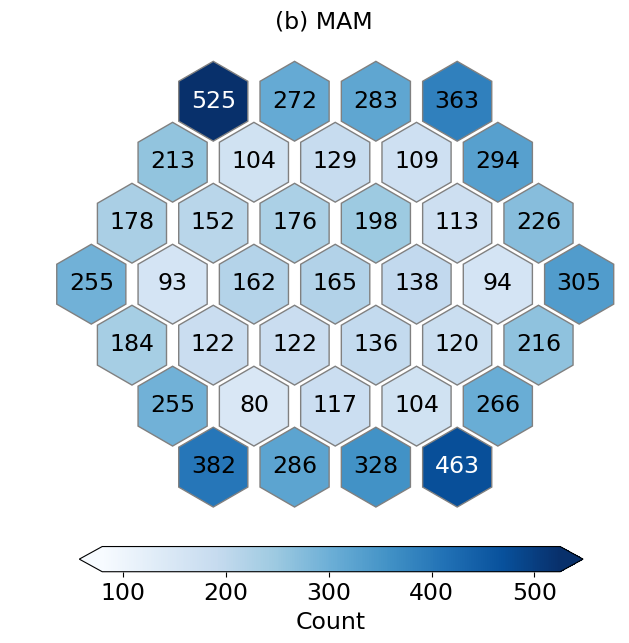

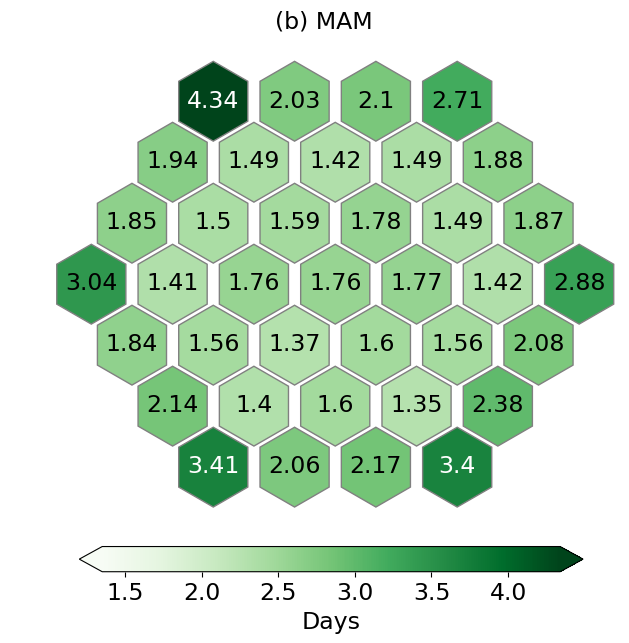

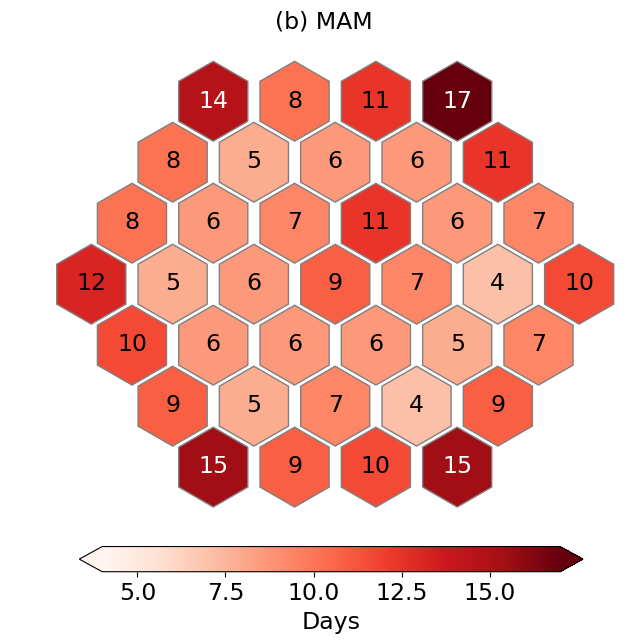

In [9]:
# Determine how consistant each weather regime is
regimePersistences = {}

for neuron in MAM_winmap:
    idxs = np.array(MAM_winmap[neuron])
    
    persistencesList = []
    diffs = np.diff(idxs)
    groups = np.split(diffs, np.where(diffs != 1)[0]+1)
    persistencesList = [len(l) for l in groups]
    persistencesList[-1] += 1
    numDays, count = np.unique(persistencesList, return_counts=True)
    #count = count / sum(count)
    
    regimePersistences[neuron] = (numDays, count)

# Caluculate the average persistence for each node
averagePersistences = {k: round(sum(v[0] * v[1]) / sum(v[1]), 2) for k, v in regimePersistences.items()}
maxPersistences = {k: max(v[0]) for k, v in regimePersistences.items()}

# Frequency plot
p = hex_frequency_plot(som, MAM_winmap, 'Blues', '(b) MAM', 'Count')
p.savefig('SOM_MAM_frequencies.pdf', transparent=True, bbox_inches='tight')

# Persistences
fig = hex_heatmap(som, averagePersistences, 'Greens', '(b) MAM', 'Days')
fig.savefig('SOM_MAM_persistences.pdf', transparent=True, bbox_inches='tight')

# Max persistence
fig = hex_heatmap(som, maxPersistences, 'Reds', '(b) MAM', 'Days')
plt.savefig('SOM_MAM_max_persistences.pdf', transparent=True, bbox_inches='tight')

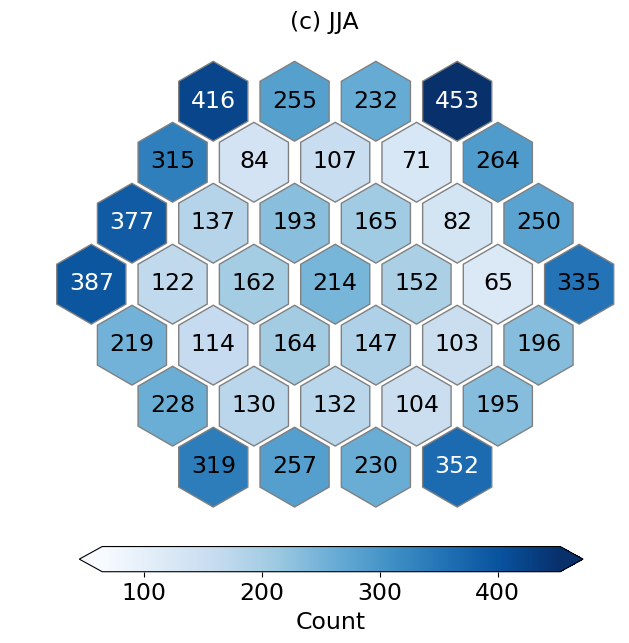

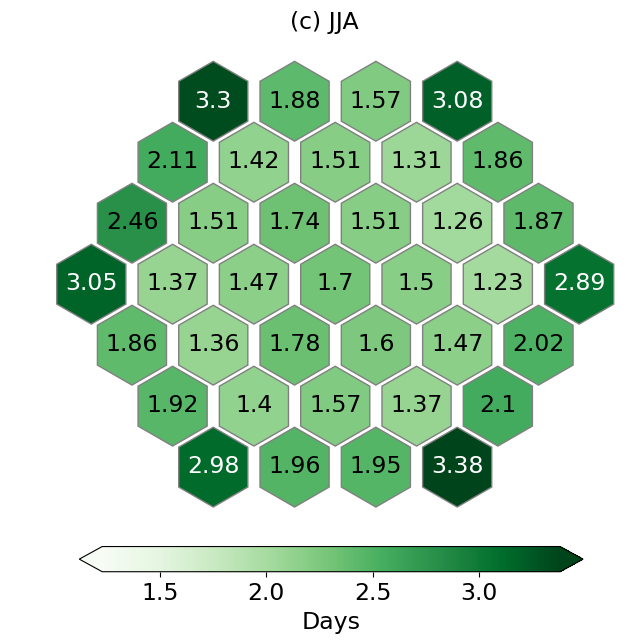

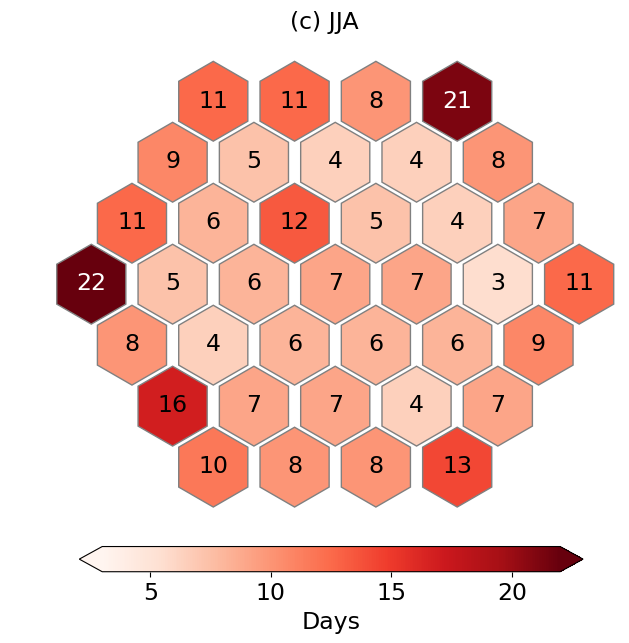

In [10]:
# Determine how consistant each weather regime is
regimePersistences = {}

for neuron in JJA_winmap:
    idxs = np.array(JJA_winmap[neuron])
    
    persistencesList = []
    diffs = np.diff(idxs)
    groups = np.split(diffs, np.where(diffs != 1)[0]+1)
    persistencesList = [len(l) for l in groups]
    persistencesList[-1] += 1
    numDays, count = np.unique(persistencesList, return_counts=True)
    #count = count / sum(count)
    
    regimePersistences[neuron] = (numDays, count)

# Caluculate the average persistence for each node
averagePersistences = {k: round(sum(v[0] * v[1]) / sum(v[1]), 2) for k, v in regimePersistences.items()}
maxPersistences = {k: max(v[0]) for k, v in regimePersistences.items()}

# Frequency plot
p = hex_frequency_plot(som, JJA_winmap, 'Blues', '(c) JJA', 'Count')
p.savefig('SOM_JJA_frequencies.pdf', transparent=True, bbox_inches='tight')

# Persistences
fig = hex_heatmap(som, averagePersistences, 'Greens', '(c) JJA', 'Days')
fig.savefig('SOM_JJA_persistences.pdf', transparent=True, bbox_inches='tight')

# Max persistence
fig = hex_heatmap(som, maxPersistences, 'Reds', '(c) JJA', 'Days')
plt.savefig('SOM_JJA_max_persistences.pdf', transparent=True, bbox_inches='tight')

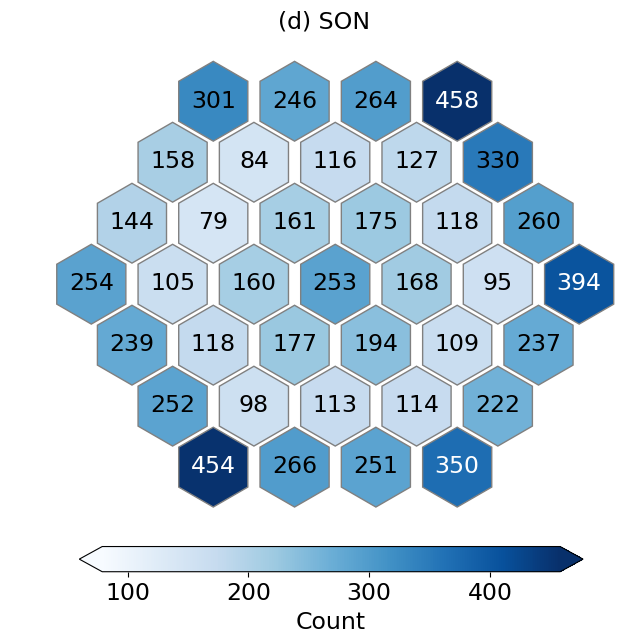

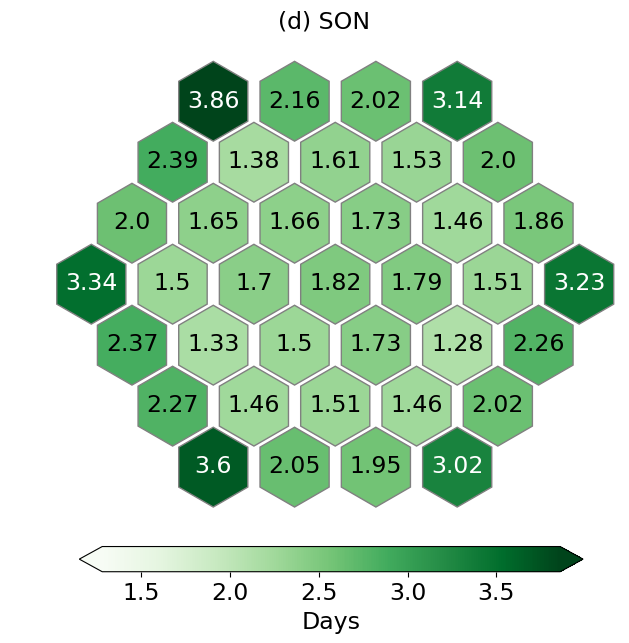

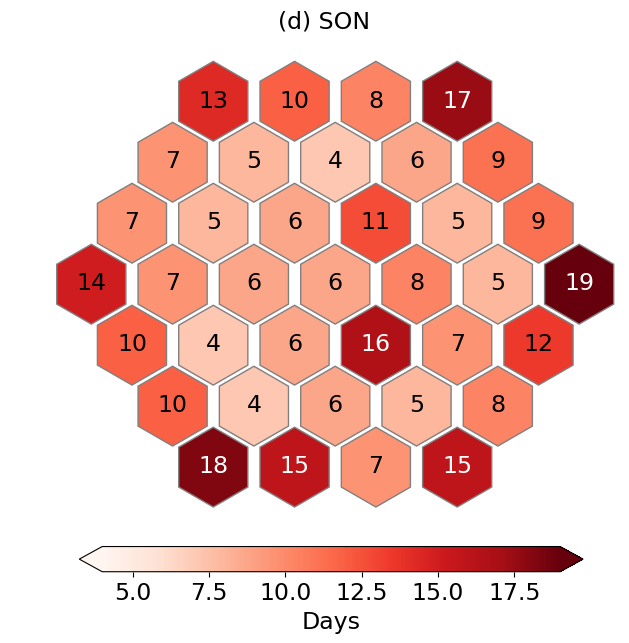

In [11]:
# Determine how consistant each weather regime is
regimePersistences = {}

for neuron in SON_winmap:
    idxs = np.array(SON_winmap[neuron])
    
    persistencesList = []
    diffs = np.diff(idxs)
    groups = np.split(diffs, np.where(diffs != 1)[0]+1)
    persistencesList = [len(l) for l in groups]
    persistencesList[-1] += 1
    numDays, count = np.unique(persistencesList, return_counts=True)
    #count = count / sum(count)
    
    regimePersistences[neuron] = (numDays, count)

# Caluculate the average persistence for each node
averagePersistences = {k: round(sum(v[0] * v[1]) / sum(v[1]), 2) for k, v in regimePersistences.items()}
maxPersistences = {k: max(v[0]) for k, v in regimePersistences.items()}

# Frequency plot
p = hex_frequency_plot(som, SON_winmap, 'Blues', '(d) SON', 'Count')
p.savefig('SOM_SON_frequencies.pdf', transparent=True, bbox_inches='tight')

# Persistences
fig = hex_heatmap(som, averagePersistences, 'Greens', '(d) SON', 'Days')
fig.savefig('SOM_SON_persistences.pdf', transparent=True, bbox_inches='tight')

# Max persistence
fig = hex_heatmap(som, maxPersistences, 'Reds', '(d) SON', 'Days')
plt.savefig('SOM_SON_max_persistences.pdf', transparent=True, bbox_inches='tight')